In [1]:
import sys
sys.path.insert(0,'/projectnb/ace-ig/michelle/micsu/')


# Load modules

In [2]:
import time
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
import scipy.signal as sig
import os
import warnings
warnings.filterwarnings("ignore")

from scipy.stats import skew 
from scipy.stats import kurtosis 


from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, KFold, cross_val_score,cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import joblib

from sklearn.metrics import (
    f1_score, precision_score, recall_score, roc_auc_score, average_precision_score, confusion_matrix
)

#import mne

import pandas as pd
from scipy.stats import ttest_1samp
from scipy.stats import chisquare

from scipy.stats import ttest_ind
import ast
from statsmodels.stats.multitest import multipletests

from sklearn.metrics import mean_squared_error
import scipy.stats as stats
def plot_ci_manual(t, s_err, n, x, x2, y2, ax=None):
    """Return an axes of confidence bands using a simple approach.
    
    Notes
    -----
    .. math:: \left| \: \hat{\mu}_{y|x0} - \mu_{y|x0} \: \right| \; \leq \; T_{n-2}^{.975} \; \hat{\sigma} \; \sqrt{\frac{1}{n}+\frac{(x_0-\bar{x})^2}{\sum_{i=1}^n{(x_i-\bar{x})^2}}}
    .. math:: \hat{\sigma} = \sqrt{\sum_{i=1}^n{\frac{(y_i-\hat{y})^2}{n-2}}}
    
    References
    ----------
    .. [1] M. Duarte.  "Curve fitting," Jupyter Notebook.
       http://nbviewer.ipython.org/github/demotu/BMC/blob/master/notebooks/CurveFitting.ipynb
    
    """
    if ax is None:
        ax = plt.gca()
    
    ci = t * s_err * np.sqrt(1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))
    ax.fill_between(x2, y2 + ci, y2 - ci, color="#b9cfe7")#, edgecolor="")

    return ax

def equation(a, b):
    """Return a 1D polynomial."""
    return np.polyval(a, b) 

# Load variables

In [5]:
model_name = "LR"
PSD_features = "AcrossTrial"
root = '/projectnb/ace-ig/deeksha/march25/input_arrays/'


In [6]:
GUIDs = np.load(root+'GUIDs.npy')
#familys = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/familys.npy')
interview_ages = np.load(root+'interview_ages.npy')
#scan_ages = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/scan_ages.npy')
#sites = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/sites.npy')

across_trial = np.load(root+'AcrossTrial_PSDfeatures.npy')
print("All subjects PSD features size ", across_trial.shape)

diagnosis = np.load(root+'diagnoses.npy')
print("Diagnosis array (true label) size ", diagnosis.shape)

sexs = np.load(root+'sexs.npy')
print("Sex array  size ", sexs.shape)

#all_srs = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/all_srs.npy')
#print("SRS raw score size ", all_srs.shape)

all_srsT = np.load(root+'all_srsT.npy')
print("SRS T score  size ", all_srsT.shape)

#globcomp = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/globcomp.npy')
#print("Glob comp - BRIEG  size ", globcomp.shape)


#motorper = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/motorper.npy')
#emoreact = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/emoreact.npy')
#sens_care = np.load('/projectnb/ace-ig/deeksha/march25/input_arrays/sens_care.npy')
#scq total
sens_adol = np.load(root+'sens_adol.npy')

All subjects PSD features size  (190, 2, 4, 128, 5)
Diagnosis array (true label) size  (190,)
Sex array  size  (190,)
SRS T score  size  (190,)


In [7]:
male_srs = all_srsT[sexs==1]
male_diag = diagnosis[sexs==1]

male_srs[male_diag==0][male_srs[male_diag==0]<999].std()

4.345220547053404

In [8]:
female_srs = all_srsT[sexs==0]
female_diag = diagnosis[sexs==0]

female_srs[female_diag==0][female_srs[female_diag==0]<999].std()

5.013869652163774

In [9]:
male_diag.sum()

55.0

# Top features

In [10]:
all_weights.shape

NameError: name 'all_weights' is not defined

In [13]:
# load absolute value of  model weights
# all_weights = np.zeros((25, 2, 4, 128, 5))

# for i in range(25):
#     flat_LR_weights = np.abs(np.load('/projectnb/ace-ig/deeksha/weights/'+str(i)+'weights.npy'))
    
#     LR_weights = np.reshape(flat_LR_weights, (2, 4, 128, 5))
#     all_weights[i] = LR_weights
all_weights =    np.abs(np.load('/projectnb/ace-ig/deeksha/march25/results/LR_AcrossTrial_weights.npy'))
# get top 5% for all models
percent = 5
num_features = flat_LR_weights.size
top_num = int(num_features*percent/100)
print("Top", str(percent),"% = ", top_num, " number of features")
top_indices_arr = np.zeros((25, top_num))

for fold in range(25):
    model_weights = all_weights[fold]
    flat_model_weights = model_weights.reshape(-1)
    
   
    sorted_indices = np.argsort(-flat_model_weights)   # negative to do it decreasing order. 
    top_indices_flat = sorted_indices[:top_num]
    #top_indices_list = np.unravel_index(top_indices_flat, model_weights.shape)
    top_indices_arr[fold] = np.array(top_indices_flat)
    
top_indices_arr = np.int64(top_indices_arr)   

Top 5 % =  256  number of features


# Band and Type distribution

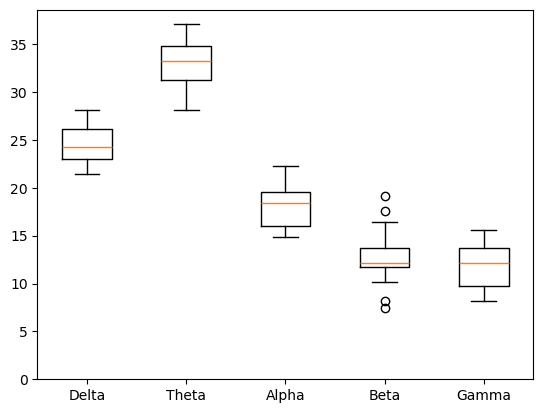

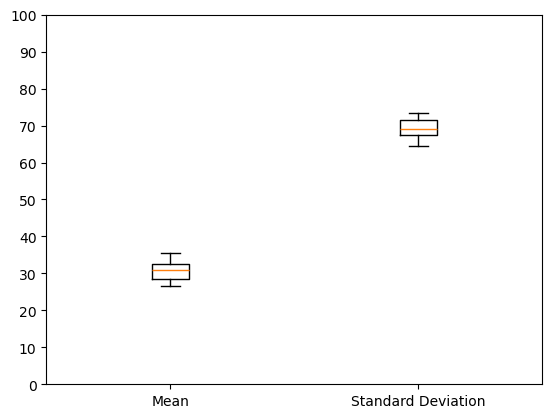

In [14]:
def count_values(array, feature_type):
    unique, counts = np.unique(array, return_counts=True)
    
    df = pd.DataFrame({
        f'{feature_type}': unique,
        'count': counts })
    df_sorted = df.sort_values(by='count', ascending=False).reset_index(drop=True)
    
    return df_sorted
    

each_band = np.zeros((25, 5))
each_feat = np.zeros((25, 2))
feature_types = ['across_trial_feature', 'band_feature', 'electrode', 'band']

for fold in range(25):
    
    x = []
    top_indices_flat = top_indices_arr[fold]
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for i in range(4):
        x.append(count_values(top_indices[i], feature_types[i]))
        
        
    df = x[3]      # this is wrong. It should x[3]     
    names = ["Delta", "Theta", "Alpha", "Beta", "Gamma"]
    num_to_name = {i: name for i, name in enumerate(names)}
    #df.loc[4] = [4, 0]
    df['band_feature_name'] = df['band'].map(num_to_name)
    df['band_feature_name'] = pd.Categorical(df['band_feature_name'], categories=names, ordered=True)
    df = df.sort_values('band_feature_name')
    df['band_percent'] = df['count']/top_num*100
    band_percents = df['band_percent'].to_numpy()
    each_band[fold] = band_percents
   
    df = x[0]
    names = ["Mean", "Standard\nDeviation"]
    num_to_name = {i: name for i, name in enumerate(names)}
    df['across_trial_feature_name'] = df['across_trial_feature'].map(num_to_name)
    df['across_trial_feature_name'] = pd.Categorical(df['across_trial_feature_name'], categories=names, ordered=True)
    df = df.sort_values('across_trial_feature_name')
    df['feature_percent'] = df['count']/top_num*100
    band_percents = df['feature_percent'].to_numpy()
    each_feat[fold] = band_percents
    #print(band_percents)
    
    #print('\n')

plt.boxplot(each_band)
plt.xticks([1, 2, 3, 4, 5], ["Delta", "Theta", "Alpha", "Beta", "Gamma"])
plt.yticks(np.arange(0, 40, 5))
plt.show()

plt.boxplot(each_feat)
plt.xticks([1, 2], ["Mean", "Standard Deviation"])
plt.yticks(np.arange(0, 110, 10))
plt.show()
    

(25, 19) [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1.]


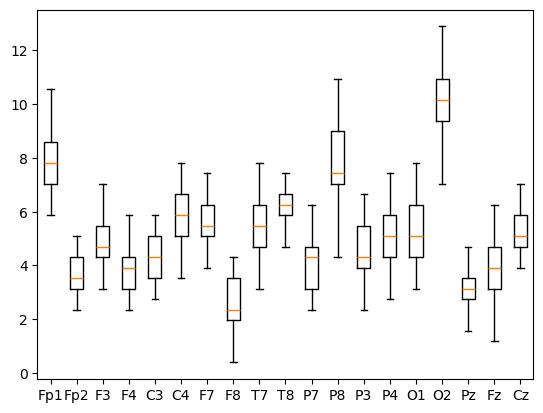

In [19]:
top_std_feats = np.zeros((25, 5, 19))

regions = [[22, 21, 25, 26, 18, 127], #FP1
           [9, 10, 14, 8, 2, 126], #FP2
           [24, 27, 23, 28, 20, 19, 13], #F3
           [124, 3, 118, 123, 117, 4, 112], #F4
           [36, 42, 41, 35, 29, 30, 37], #C3
           [104, 111, 110, 103, 93, 105, 87], #C4
           [33, 34, 38, 32, 128], #F7
           [122, 116, 121, 1, 125], #F8
           [45, 46, 40, 39, 49, 44, 43, 48], #T7
           [108, 115, 109, 102, 113, 114, 120, 119], #T8
           [58, 63, 64, 57, 56, 50], #P7
          [96, 95, 99, 100, 107, 101], #P8
           [52, 51, 59, 60, 53, 47, 54], #P3
           [92, 86, 85, 91, 97, 98, 79, 72], #P4
           [70, 71, 66, 69, 74, 65, 73, 68, 81], #01
           [83, 76, 84, 82, 89, 90, 88, 94, 75], #02
           [62, 61, 78, 67, 77], #PZ
           [11, 16, 6, 12, 5, 15, 17], #FZ
           [7, 106, 31, 80, 55]] #CZ

for temp in range(19):
    while len(regions[temp])<9:
        regions[temp].append(200)       
           
regions = np.array(regions)-1

for fold in range(25):
    top_indices_flat = top_indices_arr[fold]
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    
    for fpos in range(256):
        for reg in range(19):
            if  top_indices[2][fpos] in regions[reg]: #top_indices[0][fpos]==1 and
                top_std_feats[fold, top_indices[3][fpos], reg] += 1

top_std_feats = top_std_feats.sum(1)
top_std_feats /= top_std_feats.sum(-1)[:, None]
print(top_std_feats.shape, top_std_feats.sum(-1))

xpos = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Pz', 'Fz', 'Cz']
#xpos = ['LPFC', 'RPFC', 'LF', 'RF', 'LC', 'RC', 'LT', 'RT',  'LP', 'RP', 'LO', 'RO', 'PM', 'FM', 'CM']
#f, ax = plt.subplots(1, 5, figsize=(22, 5))
feat = [ 'std']
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

j = 0
#for j in range(5):
        
plt.boxplot(top_std_feats[:, :]*100, showfliers=False)

plt.xticks(np.arange(1, 20), xpos)
#plt.title('distribution in regions')
plt.show()

# Selection of best model 

In [20]:
import pickle

In [21]:
model = 'LR'
PSD_features = 'AcrossTrial'
with open(f"/projectnb/ace-ig/deeksha/march25/results/{model}_{PSD_features}_results.pkl", 'rb') as file:
            loaded_dict = pickle.load(file)
file.close()

maxidx = np.argmax(loaded_dict['all_auroc'])
maxidx

20

In [22]:
# select best model feature positions
# from best "auroc" - 21st model weights are the best
best_top_indices_arr = top_indices_arr[maxidx, :]
print(best_top_indices_arr.shape)

(256,)


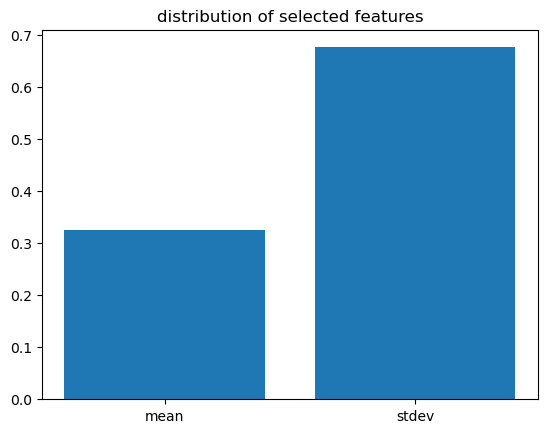

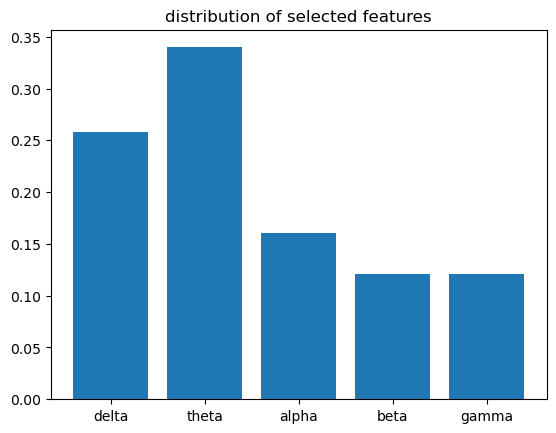

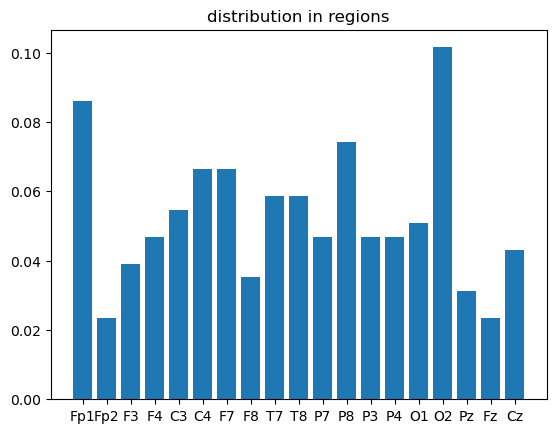

In [23]:
#std dev of which bands are important
stdbands = np.zeros(2)
for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for fpos in range(256):
        #if top_indices[0][fpos]==1:      
            stdbands[top_indices[0][fpos]] += 1
        #else:
            
stdbands /= stdbands.sum()
plt.bar(np.arange(1, 3), stdbands)
plt.xticks(np.arange(1, 3), ['mean', 'stdev'])
plt.title('distribution of selected features')
plt.show()

stdbands = np.zeros(5)
for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
    for fpos in range(256):
        #if top_indices[0][fpos]==1:      
            stdbands[top_indices[3][fpos]] += 1
        #else:
            
stdbands /= stdbands.sum()
plt.bar(np.arange(1, 6), stdbands)
plt.xticks(np.arange(1, 6), ['delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title('distribution of selected features')
plt.show()

top_std_feats = np.zeros(( 5, 19))

for fold in range(1):
    top_indices_flat = best_top_indices_arr
    top_indices = np.unravel_index(top_indices_flat, LR_weights.shape)  
    for fpos in range(256):
        trig = 0
        for reg in range(19):
            if  top_indices[2][fpos] in regions[reg]:  #top_indices[0][fpos]==1
                top_std_feats[ top_indices[3][fpos], reg] += 1
                trig += 1
        if trig == 0:
            print(top_indices[2][fpos])

top_std_feats = top_std_feats.sum(0)
top_std_feats /= top_std_feats.sum()

xpos = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Pz', 'Fz', 'Cz']
#xpos = ['LPFC', 'RPFC', 'LF', 'RF', 'LC', 'RC', 'LT', 'RT',  'LP', 'RP', 'LO', 'RO', 'PM', 'FM', 'CM']
#f, ax = plt.subplots(1, 5, figsize=(22, 5))
feat = [ 'std']
band_names = ['delta', 'theta', 'alpha', 'beta', 'gamma']

j = 0
#for j in range(5):
        
plt.bar(np.arange(1, 20), top_std_feats)

plt.xticks(np.arange(1, 20), xpos)
plt.title('distribution in regions')
plt.show()

# Correlation in all features 

In [97]:
# load features and do correlation
# mark your selected features

In [24]:
print("All features shape : ", across_trial.shape)

All features shape :  (190, 2, 4, 128, 5)


(640, 190)


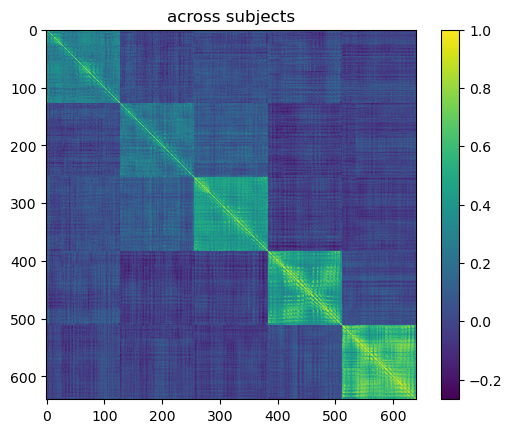

In [25]:
feats = np.transpose(across_trial, (0, 4, 3, 1, 2)).reshape(190, 5, 128, -1).mean(-1).reshape(190, -1).T
print(feats.shape)
corr = np.corrcoef(feats)
plt.imshow(corr)
plt.colorbar()
#plt.xticks(np.array([0, 1, 2, 3, 4, 5])*128, ['0', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
#plt.yticks(np.array([0, 1, 2, 3, 4, 5])*128, ['0', 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title("across subjects")
plt.show()


(190, 5, 1024)


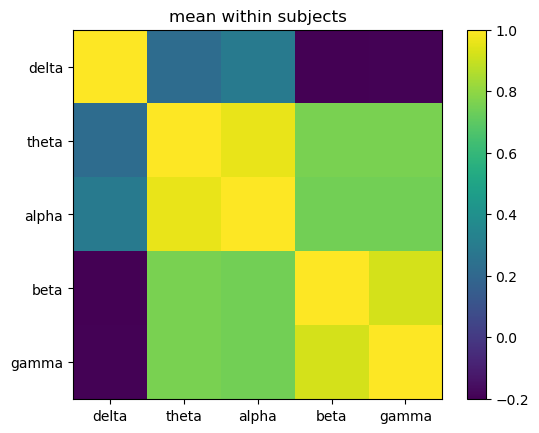

In [26]:
feats = np.transpose(across_trial, (0, 4, 3, 1, 2)).reshape(190, 5, -1)#.reshape(190, 5, -1)
print(feats.shape)
corr = np.zeros((190, 5, 5))
for j in range(190):
    corr[j]=np.corrcoef(feats[j])
corrmean = np.mean(corr, 0)
plt.imshow(corrmean)
plt.colorbar()
plt.xticks(np.arange(5), [ 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.yticks(np.arange(5), [ 'delta', 'theta', 'alpha', 'beta', 'gamma'])
plt.title("mean within subjects")
plt.show()


# Correlation of selected feats of ASD with SRS score

In [27]:
top_indices_flat = best_top_indices_arr
sel_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
#sel_indices

In [28]:
sel_indices[0].shape

(256,)

In [29]:
# sel 256 feasts
print("All features shape : ", across_trial.shape)
print("SRS size: ", all_srsT.shape)


sel_feats = np.zeros((190, 256))
for p in range(190):
    for feat in range(256):
        sel_feats[p, feat] = across_trial[p, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]
print(sel_feats.shape)        
        
        
        
        

All features shape :  (190, 2, 4, 128, 5)
SRS size:  (190,)
(190, 256)


# aggregation

In [30]:
#after aggregation of selected feats
top_indices_flat = best_top_indices_arr
sel_indices = np.unravel_index(top_indices_flat, LR_weights.shape)
#sel_indices

band = ['delta', 'theta', 'alpha', 'beta', 'gamma']
xpos = ['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'F7', 'F8', 'T7', 'T8', 'P7', 'P8', 'P3', 'P4', 'O1', 'O2', 'Pz', 'Fz', 'Cz']

aggregated_feat = np.zeros((190, 5, 19))
running_count = np.zeros((190, 5, 19))
for j in range(190):
    for feat in range(256):
        
        band =  sel_indices[3][feat]
        pos  =  sel_indices[2][feat]
        
        for r in range(19):
            if pos in regions[r]:
                elec = r
                #electrode_set = regions[r]
                #if 199 in regions[r]:
                #    t = np.where(regions[r] == 199)[0][0]
                #electrode_set = electrode_set[:t]
                
                break

        # across_trial[p, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]  
        #aggregated_feat[j, band, elec] = across_trial[j, 1][:, pos, :].sum(-1).mean(-1)
        
        aggregated_feat[j, band, elec] +=  across_trial[j, sel_indices[0][feat], sel_indices[1][feat], sel_indices[2][feat], sel_indices[3][feat]]  
        
        running_count[j, band, elec] += 1
aggregated_feat[running_count!=0] /= running_count[running_count!=0]


aggregated_feat.shape

(190, 5, 19)

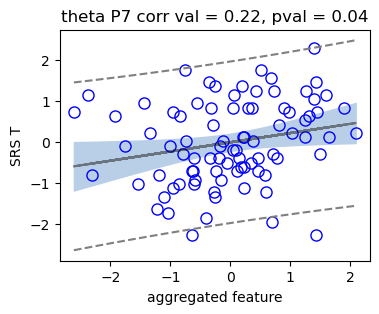

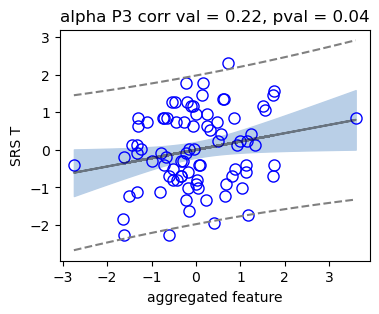

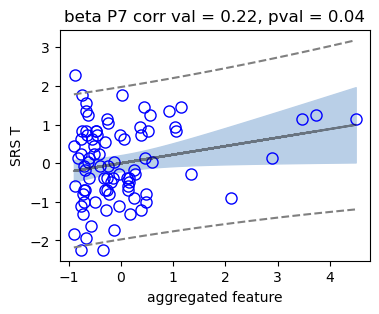

In [20]:
pheno = all_srsT
yname = 'SRS T' 

for b in range(5):
    for pos in range(19):
        x = aggregated_feat[:, b, pos]
        if x.min() == x.max() == 0:
            continue
        x = x[diagnosis==1]
        y = pheno[diagnosis==1]
        
        x = x[y<999]
        
        y = y[y<999]
        
        y = (y - y.mean())/ y.std()
        x = (x-x.mean())/x.std()
        
        corr, pval = stats.pearsonr(x, y)
        
        if abs(corr)>0.1:
            
            if pval<0.05:
                #print(np.round(corr, 2),  band[b], xpos[pos], np.round(pval, 2), 'significant')
                
                p, cov = np.polyfit(x, y, 1, cov=True)                     # parameters and covariance from of the fit of 1-D polynom.
                y_model = equation(p, x)                                   # model using the fit parameters; NOTE: parameters here are coefficients

                # Statistics
                n = y.size                                           # number of observations
                m = p.size                                                 # number of parameters
                dof = n - m                                                # degrees of freedom
                t = stats.t.ppf(0.975, n - m)                              # t-statistic; used for CI and PI bands

                # Estimates of Error in Data/Model
                resid = y - y_model                                        # residuals; diff. actual data from predicted values
                chi2 = np.sum((resid / y_model)**2)                        # chi-squared; estimates error in data
                chi2_red = chi2 / dof                                      # reduced chi-squared; measures goodness of fit
                s_err = np.sqrt(np.sum(resid**2) / dof)                    # standard deviation of the error

                # Plotting --------------------------------------------------------------------
                fig, ax = plt.subplots(figsize=(4,3))

                # Data
                ax.plot(
                    x, y, "o", color="#b9cfe7", markersize=8, 
                    markeredgewidth=1, markeredgecolor="b", markerfacecolor="None"
                )

                # Fit
                ax.plot(x, y_model, "-", color="0.1", linewidth=1.5, alpha=0.5, label="Fit")  

                x2 = np.linspace(np.min(x), np.max(x), 100)
                y2 = equation(p, x2)

                # Confidence Interval (select one)
                plot_ci_manual(t, s_err, n, x, x2, y2, ax=ax)
                #plot_ci_bootstrap(x, y, resid, ax=ax)

                # Prediction Interval
                pi = t * s_err * np.sqrt(1 + 1/n + (x2 - np.mean(x))**2 / np.sum((x - np.mean(x))**2))   
                ax.fill_between(x2, y2 + pi, y2 - pi, color="None", linestyle="--")
                ax.plot(x2, y2 - pi, "--", color="0.5", label="95% Prediction Limits")
                ax.plot(x2, y2 + pi, "--", color="0.5")
                plt.title(band_names[b]+' '+xpos[pos]+" corr val = " +str(np.round(corr, 2)) + ', pval = '+str(np.round(pval, 2)))
                plt.xlabel('aggregated feature')
                plt.ylabel(yname)
                plt.show()
    #print('\n')




# Patrial Correlations

In [32]:
# make dataframes

# make datafframes

df = {'diagnosis' : diagnosis,
       'sex': sexs,
     'srsT': all_srsT, 
      'interview_age': interview_ages, 
      'GUID': GUIDs,
      'sens_adol':sens_adol
     }  #add GUID, family, interview_age, scan_age, site


for b, band in enumerate(band_names):
    for p, pos in enumerate(xpos):
    
        keyname = 'aggfeat_'+band + '_' + pos
        df[keyname] = aggregated_feat[:, b, p]

df = pd.DataFrame(df)


In [33]:
from pingouin import partial_corr

In [34]:
import statsmodels.stats.multitest as multi

In [64]:
ytype = 'srsT'

In [65]:
newdf = df[df[ytype] != 999]
newdf[ytype] = (newdf[ytype] - newdf[ytype].mean())/newdf[ytype].std()

rvals, pvals = [], []
for b, band in enumerate(band_names):
    for p, pos in enumerate(xpos):
        xtype = f"aggfeat_{band}_{pos}"
        if not newdf[xtype].std() == 0:    
            newdf[xtype] = (newdf[xtype] - newdf[xtype].mean())/newdf[xtype].std()
            res = partial_corr(data=newdf, x=xtype, y=ytype,covar=[ 'interview_age',  'sex'], method='pearson')
            pvals.append(res['p-val'].item())
            rvals.append(res['r'].item())
            if res['p-val'].item() < 0.05:
                print(band, pos, res['p-val'].item(), res['r'].item())
        else:
            pvals.append(np.nan)
            rvals.append(np.nan)
            
        

newpvals = []
for p in pvals:
    if not np.isnan(p):
        newpvals.append(p)
#newpvals
reject, p_values_corrected, _, _ = multi.multipletests(newpvals, alpha=0.05, method='fdr_bh')
adjpvals = []
count = 0
for p in pvals:
    if not np.isnan(p):
        adjpvals.append(p_values_corrected[count])
        count += 1
    else:
        adjpvals.append(np.nan)


delta Fp1 0.02416001123736121 -0.17138435694782211
delta F7 0.03878624024358802 0.1572701815188483
delta O1 0.009033076105856293 0.19796219912068933
delta Fz 0.009106542194664027 0.19775622197555978
theta F7 0.04543217908559014 -0.15232066522586704
theta O1 0.010003862431132025 -0.1953522856612741
theta O2 0.002867522229121054 -0.22539600960034425
theta Cz 0.027037273451545624 -0.1681181354479368
alpha Fp2 0.007861824720250538 -0.20146417942470343
alpha P3 0.013829908686039139 0.18685906828409318
alpha P4 0.0064995424248321405 0.20617519257117645
alpha O1 0.0058689717481257364 0.20866177764129024
beta Fp1 0.001027985431031812 -0.24748316055078953
beta C4 0.016315063461490698 -0.18239256511565055
beta F8 0.0013053337324797625 0.2425159671041823
beta P7 0.00044793191785236295 0.2640307802204241
beta O2 6.01194511987435e-05 -0.3001642673867641
beta Pz 0.0011313375922519014 -0.245502893251412
gamma Fp1 0.0009142337303484011 0.2498859988694424
gamma P3 0.004115160060170124 0.217106838356514

In [59]:
reject.sum()

3

In [60]:
for j in range(5):

    print(('& ').join([str(round(p, 3)) for p in rvals[19*j:19*(j+1)]]))


print('%')


for j in range(5):

    print(('& ').join([str(round(p, 3)) for p in adjpvals[19*j:19*(j+1)]]))

-0.151& -0.043& nan& -0.043& 0.117& 0.011& 0.15& nan& 0.018& 0.028& -0.105& 0.001& 0.027& -0.003& 0.129& 0.027& nan& 0.079& 0.025
-0.133& 0.032& -0.086& 0.12& 0.075& 0.087& -0.03& -0.011& 0.074& 0.03& 0.082& 0.004& 0.032& 0.097& -0.181& -0.211& -0.03& nan& -0.115
nan& -0.136& 0.048& -0.05& 0.063& -0.043& -0.049& 0.064& -0.033& 0.059& -0.019& 0.098& 0.118& 0.215& 0.199& 0.163& 0.082& -0.008& -0.014
-0.325& nan& nan& -0.056& 0.04& -0.198& nan& 0.142& nan& nan& 0.172& -0.078& 0.001& -0.192& 0.055& -0.274& -0.278& nan& -0.03
0.197& 0.086& nan& 0.033& -0.123& 0.02& 0.122& 0.125& -0.096& nan& 0.044& -0.075& 0.196& -0.097& -0.01& 0.054& nan& -0.009& nan
%
0.219& 0.835& nan& 0.835& 0.353& 0.959& 0.219& nan& 0.923& 0.868& 0.459& 0.989& 0.868& 0.989& 0.338& 0.868& nan& 0.608& 0.874
0.309& 0.868& 0.574& 0.353& 0.618& 0.574& 0.868& 0.959& 0.618& 0.868& 0.591& 0.989& 0.868& 0.501& 0.097& 0.062& 0.868& nan& 0.359
nan& 0.301& 0.819& 0.819& 0.734& 0.835& 0.819& 0.731& 0.868& 0.766& 0.919& 0.501& 0.353